# `cloudwatcher` Python API usage

The purpose of this page is to provide a quick overview of the `cloudwatcher` Python API. The package consists of two user-facing classes:

- `MetricWatcher`: This class is used to interact with AWS CloudWatch metrics.
- `LogWatcher`: This class is used to interact with AWS CloudWatch logs.

Both of these classes inherit from the `CloudWatcher` class.

## `MetricWatcher`: convenient interface to AWS CloudWatch metrics

`MetricWatcher` can be used to interact with AWS CloudWatch metrics. 

### `MetricWatcher` initialization

As described in the Login credentials section, the AWS credentials can be sourced from environment variables: `AWS_ACCESS_KEY_ID`, `AWS_SECRET_ACCESS_KEY`, `AWS_SESSION_TOKEN`.
Alternatively, you can pass the values as arguments to the `MetricWatcher` constructor.

In [60]:
from cloudwatcher.metricwatcher import MetricWatcher
from cloudwatcher.preset import Dimension
from dotenv import load_dotenv
import os

load_dotenv()

instance_id = os.environ.get("INSTANCE_ID")
mw = MetricWatcher(
    namespace="NepheleNamespaceEC2",
    metric_name="mem_used",
    metric_id="mem_used",
    metric_unit="Bytes",
    dimensions_list=[Dimension(Name="InstanceId", Value=instance_id)],
)

### `MetricWatcher` presets

As you can see there are multiple arguments that can be passed to `MetricWatcher` constructor. In order to improve the UX when using `MetricWatcher` `cloudwatcher` package provides a few presets that can be used to query the data reported by `CloudWatchAgent` within certain systems. Additionally, custom presets can be defined by the user and used in the same way.

Presets are JSON-formatted files that provide parameter bundles for `MetricWatcher` initialization.

#### Usage

Listing available presets:


In [61]:
from cloudwatcher.preset import PresetFilesInventory
from rich.console import Console

pfi = PresetFilesInventory()
Console().print(pfi.presets_table)

                 Presets available in: /Users/stolarczykmj/code/cloudwatcher/cloudwatcher/presets                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Name                                   ┃ Path                                                                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ nephele_disk_used_percent              │ /Users/stolarczykmj/code/cloudwatcher/cloudwatcher/presets/nephele_di… │
│ nephele_mem_cached                     │ /Users/stolarczykmj/code/cloudwatcher/cloudwatcher/presets/nephele_me… │
│ nephele_mem                            │ /Users/stolarczykmj/code/cloudwatcher/cloudwatcher/presets/nephele_me… │
│ nephele_disk_used_percent_nephele_data │ /Users/stolarczykmj/code/cloudwatcher/cloudwatcher/presets/nephele_di… │
│ nephele_cpu_usage_user                 │ /Users/stolarczykmj/code/cloudwatcher/cloudwatcher/presets/nephele_cp… │
│ nephele_processes_dead                 │ /Users/stolarczykmj/code/cloudwatcher/cloudwatcher/presets/nephele_pr… │
│ nephele_swap_used_percent              │ /Users/stolarczykmj/code/cloudwatcher/cloudwatcher/presets/nephele_sw… │
│ nephele_swap_used                      │ /Users/stolarczykmj/code/cloudwatcher/cloudwatcher/presets/nephele_sw… │
└────────────────────────────────────────┴────────────────────────────────────────────────────────────────────────┘

Using a preset:

In [62]:
from cloudwatcher.preset import MetricWatcherSetup
mw_setup = MetricWatcherSetup.from_json(pfi.get_preset_path("nephele_mem"))
mw_setup.upsert_dimensions([f"InstanceId:{instance_id}"])
mw = MetricWatcher(**mw_setup.to_dict())
query_kwargs = {
    "days": 5,
    "hours": 0,
    "minutes": 0,
    "stat": "Maximum",
    "period": 60,
}
response = mw.query_ec2_metrics(**query_kwargs)





### Querying AWS CloudWatch metrics

In order to specify the EC2 instace query settings (period, granularity, etc.), the user would need to provide multiple parameters. To make it easier, there are a few sensible presets that can be used to select the query settings, which are passed to `query_ec2_metrics` method. These presets are defined to query the data reported by `CloudWatchAgent` within the last day, hour or minute.

The presets can be used by passing the `query_preset` argument to the functions presented below. Alternatively, users can pass `query_kwargs` argument, which overrides the preset values.

### Logging methods

There is a method that can be used to log the metric to the screen. The EC2 instance is automatically queried if the query response is not provided.

### File saving methods

There are number of methods that can be used to save the metric data to a file. Again, the EC2 instance is automatically queried if the query response is not provided.


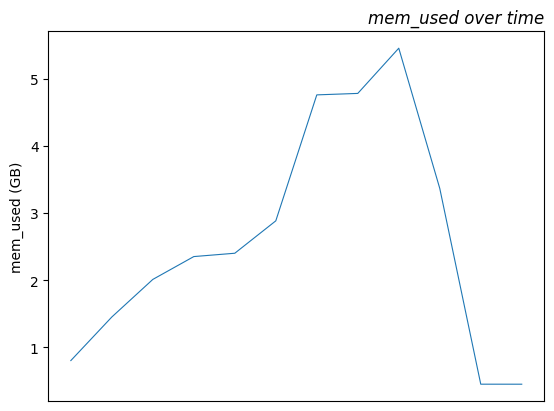

In [63]:
mw.save_metric_plot(file_path=f"/tmp/{instance_id}_plot.png", query_kwargs=query_kwargs)
mw.save_metric_csv(file_path=f"/tmp/{instance_id}_metric.csv", query_kwargs=query_kwargs)
mw.save_metric_json(file_path=f"/tmp/{instance_id}_metric.json", query_kwargs=query_kwargs)
mw.save_response_json(file_path=f"/tmp/{instance_id}_response.json", query_kwargs=query_kwargs)

### Manual EC2 querying

For users that require more control over the EC2 instance query settings, the `query_ec2_metrics` method can be used to manually query the EC2 instance. For instance it allows to fine tune the query period settings.

In [64]:
FINE_TUNED_SETTINGS = {
    "days": 5,
    "hours": 0,
    "minutes": 0,
    "stat": "Maximum",
    "period": 60,
}
response = mw.query_ec2_metrics(**FINE_TUNED_SETTINGS)

response["ResponseMetadata"]

{'RequestId': '52074cc6-470c-470a-a52d-5cab88fbdda0',
 'HTTPStatusCode': 200,
 'HTTPHeaders': {'x-amzn-requestid': '52074cc6-470c-470a-a52d-5cab88fbdda0',
  'content-type': 'text/xml',
  'content-length': '1596',
  'date': 'Wed, 25 Jan 2023 20:53:18 GMT'},
 'RetryAttempts': 0}

### `TimedMetric` dataclass

Internally, the package uses `TimedMetric` dataclass to store the metric data. This dataclass is used to store the metric data and provide a convenient interface to access the data. It can be also used to interact with the metric data by the user.

In [65]:
response = mw.query_ec2_metrics(**FINE_TUNED_SETTINGS)
timed_metric = mw.timed_metric_factory(response)[0]
print(timed_metric.__class__)
timed_metric.values[1:10]

<class 'cloudwatcher.metric_handlers.TimedMetric'>


[487075840.0,
 3613966336.0,
 5853335552.0,
 5131206656.0,
 5107838976.0,
 3095851008.0,
 2578575360.0,
 2525331456.0,
 2160402432.0]

## `LogWatcher`: convenient interface to AWS CloudWatch logs

`LogWatcher` can be used to interact with AWS CloudWatch logs.

### `LogWatcher` initialization

As described in the Login credentials section, the AWS credentials can be sourced from environment variables: `AWS_ACCESS_KEY_ID`, `AWS_SECRET_ACCESS_KEY`, `AWS_SESSION_TOKEN`.
Alternatively, you can pass the values as arguments to the `LogWatcher` constructor.

In [66]:
from cloudwatcher.logwatcher import LogWatcher
from dotenv import load_dotenv
import os

load_dotenv()

lw = LogWatcher(
    log_group_name=os.environ.get("LOG_GROUP_NAME"),
    log_stream_name=os.environ.get("LOG_STREAM_NAME"),
)

Importantly, you can also provide the start token for the log, which will be used to determine the starting point of the log query.

### Log streaming

`LogWatcher` provides a convenient interface to stream the logs from AWS CloudWatch. There are 2 relevant parameters in `stream_cloudwatch_logs` method:

- `events_limit` - the maximum number of events to be returned. If the value is set to `None`, 1000 events are returned
- `max_retry_attempts` - the maximum number of retry attempts to be made if the query results with an empty log

The `stream_cloudwatch_logs` method returns a generator that yields the log events, for example in a `for` loop. In the example below , we use `next` to get the first event from the generator.

In [67]:
streamer = lw.stream_cloudwatch_logs(events_limit=2, max_retry_attempts=2)
next(streamer)

([{'timestamp': 1673452248277,
   'message': '[2023-01-11 10:50:47,354 - INFO] Nephele, developed by BCBB/OCICB/NIAID/NIH version: 2.21.8, tag: Nephele_2022_December_22, commit: caa66b1',
   'ingestionTime': 1673452249530},
  {'timestamp': 1673452248277,
   'message': '[2023-01-11 10:50:47,354 - INFO] Python version: 3.8.13',
   'ingestionTime': 1673452249530}],
 'f/37319232190733584015059832158212944362474954267242725377/s')

As you can see, the log events are returned as a `Tuple[List[Dict], str]`, where the first element is a list of log events and the second element is the next token. The next token can be used to get the next batch of log events. The token can be provided to the `LogWatcher` constructor to start streaming from the last event.

### Retrieving all logs

Alternatively, the `return_formatted_logs` method can be used to retrieve all the logs. This method returns a `Tuple[str,str]`, where the first element is the formatted log and the second element is the next token. 

In [68]:
formatted_logs = lw.return_formatted_logs()

print(f"Token: {formatted_logs[1]}")
print(f"Log first 1000 characters: \n{formatted_logs[0][0:1000]}")


Token: f/37319244494578777554547009354944727373821660766530404351/s
Log first 1000 characters: 
[11-01-2023 10:50:48 UTC] Nephele, developed by BCBB/OCICB/NIAID/NIH version: 2.21.8, tag: Nephele_2022_December_22, commit: caa66b1
[11-01-2023 10:50:48 UTC] Python version: 3.8.13
[11-01-2023 10:50:48 UTC] Current time: 2023-01-11 10:50
[11-01-2023 10:50:48 UTC] Pipeline name: DADA2
[11-01-2023 10:50:48 UTC] Job Description: test
[11-01-2023 10:50:48 UTC] Job parameters
[11-01-2023 10:50:48 UTC] job_id: d5b6be48d21e
[11-01-2023 10:50:48 UTC] inputs_dir: None
[11-01-2023 10:50:48 UTC] outputs_dir: None
[11-01-2023 10:50:48 UTC] map_file: <_io.TextIOWrapper name='/nephele_data/inputs/N2_16S_example_mapping_file_min_corrected.txt' mode='r' encoding='UTF-8'>
[11-01-2023 10:50:48 UTC] data_type: PE
[11-01-2023 10:50:48 UTC] wurlitzer_stdout: file
[11-01-2023 10:50:48 UTC] wurlitzer_stderr: file
[11-01-2023 10:50:48 UTC] ion_torrent: False
[11-01-2023 10:50:48 UTC] trimleft_fwd: 0
[11-01-2023 10